# Classifying Depression Levels Based on Reddit Content using NLP approach

NETID: By82

Note to Professor: Some cells are empty because as I am doing the analysis, I accidentally clicked shift+enter on the code cell. Since it is not a good use of time to rerun the notebook as training and testing with a NVIDIA 4070 can take over 8 hours and I already done a lot of rerunning, I simply save the copy and paste the values I had before I cleared the cell.  

## Problem Statement

Can we accurately predict the level or likelihood of depression in a user based on the content they post across different subreddits?


## Hypothesis
The language used by individuals in mental health-related subreddits (such as "Depression" and "SuicideWatch") contains specific linguistic markers that can be used to predict depressive symptoms. While leveraging these features with existing powerful large language model we can classify individual's depression status through their reddit post with reasonable result (90% above). 

## Motivation

Depression is a widespread mental health condition that affects millions of individuals globally, often going undiagnosed or untreated due to barriers such as stigma, lack of resources, and limited access to mental health professionals. Early detection of depression is crucial for providing timely intervention and support, potentially preventing severe consequences such as chronic mental health issues or suicide.

The motivation behind this work is to leverage advancements in Artificial Intelligence (AI) like LLM to assist in diagnosing depression by analyzing linguistic patterns in text data. AI models, particularly in Natural Language Processing (NLP), have the capability to process and interpret large volumes of textual information, identifying subtle cues and patterns that may be indicative of mental health concerns. By augmenting traditional methods of diagnosis, AI can serve as a valuable tool for mental health practitioners, offering scalable, efficient, and objective insights.

This approach aims to bridge the gap in mental health care by providing an additional layer of support for early identification, especially in settings where access to professional care is limited. Ultimately, the goal is to enhance the ability to detect depression and empower individuals and professionals with tools that can make a meaningful impact on mental health outcomes.

## Experiment Design and Evaluation

We use natural language processing (NLP) techniques to extract features from the Reddit posts. Train machine learning models logistic regression (baseline) and fine-tuned Bert to predict whether a post is indicative of depression.

We will evaluate the model's accuracy using precision, recall, and F1 score. Conduct a qualitative analysis of the most important features to understand which language patterns are most predictive.

## Connections to Humanities

In the humanities, studying language is a key focus. By analyzing the language used in Reddit posts, we can explore how cultural and social factors shape the ways people express mental health issues. For example, language patterns can reveal how different groups articulate their experiences of depression, the metaphors they use, or the influence of cultural stigma on discussing mental health. This seems like a task for BERT because the bidirectional architecture of BERT handles the ability to understand the full context of a word by analyzing the surrounding words in both directions. 

Online forums like Reddit can be considered spaces where cultural production occurs. These spaces produce cultural narratives about mental health through shared stories, coping mechanisms, and expressions of emotional experiences. By predicting depression from posts, we are engaging with the content produced by users, which reflects broader cultural attitudes and discourses on mental health.

Additionally, we want to analyze how language and content around mental health are shaped by the digital medium and how these cultural products (posts, stories, discussions) impact individuals' perceptions of mental well-being.


## Dataset

Depression Definition:
Depression is a mood disorder that causes a persistent feeling of sadness and loss of interest [1].

In our Reddit Dataset from https://www.kaggle.com/datasets/rishabhkausish/reddit-depression-dataset/data, the reddit posts are classified as depression based solely on textual evidence and not clinical diagnosis. Identifying whethere the user is depressed based on their social media post is challenging because there is this question of "Who are you to say that this person is depressed?" Many people are skeptical of using AI to diagnose depression. I want to be clear that this project is not to be used for self-diagnosis, but rather to see the potential of NLP to classify depression with attention.

The dataset is a total of 1.17 GB with over 2 million posts. 


In [2]:
#Imported modules
import pandas as pd
import matplotlib.pyplot as plt
from transformers import BertTokenizerFast, BertForSequenceClassification, AdamW, BertConfig

import torch 
from torch.utils.data import Dataset, DataLoader, random_split
from torch.optim.lr_scheduler import StepLR

import os
from tqdm import tqdm

from torch.optim import AdamW  # Using PyTorch's AdamW
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from torch.amp import GradScaler, autocast
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np



### Load Dataset

In [9]:
df = pd.read_csv("reddit_depression_dataset.csv")

df.to_pickle("dataframe.pkl")
df.sample(5)
# df = pd.read_pickle("dataframe.pkl")


C:\Users\Benja\AppData\Local\Temp\ipykernel_6152\340394629.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("reddit_depression_dataset.csv")


,Unnamed: 0,subreddit,title,body,upvotes,created_utc,num_comments,label
1268575,4691721,teenagers,"Whats the difference between pan, bi and omni ...",I'm definitely one of them but I don't know wh...,7.0,1.597062e+09,35.0,0.0
1624212,6043204,teenagers,My sister is now blasting Caramelldansen god h...,NaN,5.0,1.621804e+09,18.0,0.0
1352891,5035579,teenagers,Come and think of it (part 63),Today is Christmas eve eve eve eve eve eve e...,7.0,1.603031e+09,NaN,0.0
329669,1564281,teenagers,fuck off,"amazon, fuck off with your ""gifts for her"" i'v...",8.0,1.548463e+09,4.0,0.0
2358824,10028694,depression,Cry,I was sitting down with my family even though ...,7.0,1.565134e+09,1.0,1.0


We can see that the Data Card is...

Subreddit: The subreddit where the post was shared

Title: The title provided by the user for the post

Body: The content of the post written by the user

Upvotes: The number of upvotes the post received

Created UTC : The time the post was created, given in UTC epoch time

Number of Comments: The total count of comments on the post

Label: The category assigned to the post, where 0 indicates normal and 1 indicates depressed (Target)

The features we will be working with are title and body. 

### Data Processing 

In [10]:
#rename "body column"
df = df.rename(columns={"body": "content"}).drop("Unnamed: 0", axis = 1)
#axis = 1 is column
df.columns


Index(['subreddit', 'title', 'content', 'upvotes', 'created_utc',
       'num_comments', 'label'],
      dtype='object')

I renamed the "body" column to "content" based on my preference. I think it makes more sense to call the textual post contents rather than body. 

In [11]:
df['subreddit'].unique()

array(['DeepThoughts', 'teenagers', '15', '6', '30', '5', '12', '16', nan,
       '7', '4', '61', '10', '9', '8', '107', '11', 'happy',
       'SuicideWatch', '1402326041', 'depression', '31', '101', '27',
       '47'], dtype=object)

I observed that certain subreddits in the dataset are named with numbers instead of meaningful names (e.g., 123, 45678, etc.). These subreddits may represent temporary, experimental, or less descriptive community forums, which do not provide clear contextual information for analysis. Additionally, the number subreddits may be noise from scraping. Since the dataset is large, removing number subreddits' data would not affect the experiment. 

In [12]:
df['label'].unique()

array([ 0., nan,  1.])

I observed that we have 3 labels (0, nan, and 1). We want to clean our dataset from nan labeled reddit posts because it is likely a mistake in the scraping. Additionally nan does not tell us anything about a post being depressed or not.

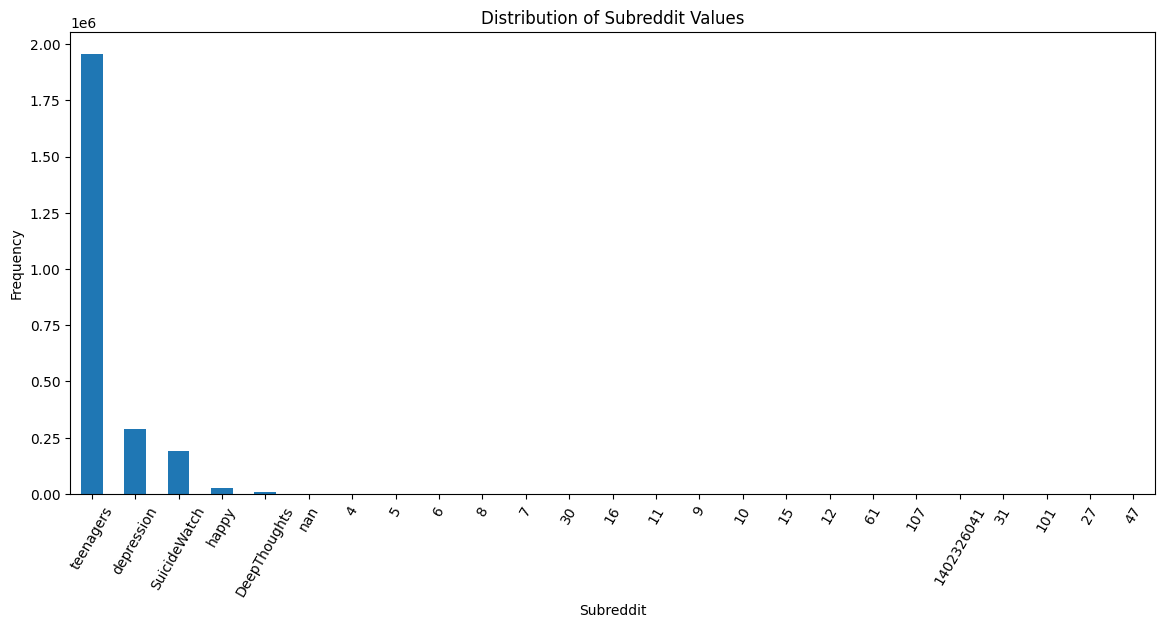

In [13]:
# Count the occurrences of each unique value
subreddit_counts = df['subreddit'].value_counts(dropna=False)

# Plot the distribution
plt.figure(figsize=(14, 6))
subreddit_counts.plot(kind='bar')
plt.title('Distribution of Subreddit Values')
plt.xlabel('Subreddit')
plt.ylabel('Frequency')
plt.xticks(rotation=60) 
plt.show()

Looking at the plot above we learn that the number subreddits are likely errors from scraping since there are little to no data. So we will filter them out of our dataste.

#### Data Cleaning

Observe that the dataset contains Reddit posts from 5 subreddits: DeepThoughts, teenagers, SuicideWatch, depression, and happy.

My prior is that we will most likely find more depression posts in SuicideWatch and depression. Happy will contain less language that relates to depression. I think posts from DeepThoughts and teenagers can expose languages that can be found in depressed posts.

In [14]:
# subreddits to keep
subreddits_to_keep = ['DeepThoughts', 'teenagers', 'SuicideWatch', 'depression', 'happy']

# Filter the DataFrame
filtered_df = df[df['subreddit'].isin(subreddits_to_keep) ]

# Reset index (optional)
filtered_df.reset_index(drop=True, inplace=True)

# Filter out rows with NaN labels
filtered_df = filtered_df[filtered_df['label'].notna()]

# Reset index (optional)
filtered_df.reset_index(drop=True, inplace=True)

In [15]:
print(f'Number of entries in the dataset: {len(filtered_df)}')
print(f'Number of entries in each columns: \n{filtered_df.count()}')


Number of entries in the dataset: 2470672
Number of entries in each columns: 
subreddit       2470672
title           2470669
content         2009643
upvotes         2470672
created_utc     2470672
num_comments    2356801
label           2470672
dtype: int64


We have around 2.4 million data after filtering data with numbered subreddits. Observe that some content are none since the number of content is less than 2.4 million. Instead of filtering data entries with none we want to replace the data with an empty string.

#### Examining Depressed Post

Before modifying the content of our dataset, I want to see what a depressed post is like.

In [16]:
# Filter rows where 'label' is 1
label_1_df = filtered_df[filtered_df['label'] == 1]

# Sample 10 rows from the filtered DataFrame
label_1_sample = label_1_df.sample(10)

# Get the 'content' column from the sampled rows
sampled_content = label_1_sample['content']


print(sampled_content.iloc[3])



When things like that happen, I just want to kill myself. I mean obviously no one cares, and part of me wants to show them in a way they can't miss, that they are wrong about how *they think* I am feeling. 

I am not fine. Right now all I really want to do is cut myself and research ways to kill myself. For whatever reason, I am not doing that. That thing that humans have that keeps us going despite how shitty we feel and how much we have tried, I hate that thing. I hate that for whatever reason, I seem to have so much of it.

I finally went to my doctor today to get some medication. I pretty much had to beg him to prescribe it to me because he said it didn't seem like I needed it. Now, here I am so close to looking up ways to quickly and easily kill myself. Why do things like this have to get so bad before anyone starts to help? Maybe I should put a huge slash in my wrist and wear short sleeves. Maybe then I will get some help. Maybe.

Edit: Don't tell me "things will get better". Tha

When analyzing the language in this post, several patterns emerge that are characteristic of individuals experiencing severe depression or mental distress. The post is filled with expressions of hopelessness and despair, such as "I just want to kill myself", "I am not fine", and "I hate that thing". These phrases highlight a deep sense of emotional pain and a lack of belief that things can improve. This kind of language reflects a core symptom of depression, where individuals feel overwhelmed by their struggles and perceive little or no hope for a better future.

The post also conveys a strong desire for recognition and validation. Statements like "No one cares" and "Maybe then I will get some help" suggest that the individual feels ignored or dismissed by those around them. This need to be seen and heard is a common theme among those experiencing depression, as they often struggle with feelings of invisibility or neglect. The individual’s frustration is particularly evident when they express dissatisfaction with professional support, such as in the statement "I had to beg him to prescribe it to me." This reflects systemic challenges in accessing mental health care and a perception of indifference from professionals and others.

Another prominent pattern is intense self-criticism and negative self-perception. The individual expresses frustration with themselves, as seen in the line "I hate that for whatever reason, I seem to have so much of it," referring to their perseverance despite the emotional pain. This self-directed negativity is a hallmark of depressive thought patterns, where individuals often view themselves through a distorted and overly critical lens.

The post also highlights the physical manifestations of emotional pain, with mentions of self-harm such as "cut myself" and "put a huge slash in my wrist." These references suggest that the individual may view physical pain as a way to cope with or communicate their emotional distress. This reinforces the severity of their mental state and the urgent need for intervention and support.

Towards the end of the post, the individual calls for practical solutions rather than empty reassurances. Their plea, "Tell me HOW to make things get better. Maybe even help me make things get better," reflects a frustration with vague encouragement and a desire for actionable advice. This indicates that while they dismiss platitudes, they are still seeking help and hope for change. It underscores the importance of providing specific, tangible steps to support individuals in similar states of distress.

The language also reveals patterns of isolation, with a heavy use of first-person pronouns such as "I," "me," and "my." This self-focus often accompanies feelings of loneliness and rumination, which are common in depressive states. Additionally, the individual’s edit, "Don’t tell me 'things will get better'," shows a preemptive rejection of unhelpful responses they have likely received in the past, further emphasizing their need for empathetic and practical support.

In summary, the language in this post demonstrates the deep emotional pain, frustration, and longing for help experienced by individuals facing severe depression. It underscores the importance of listening to and addressing their needs with empathy and actionable solutions, as well as the critical role of timely and effective mental health care. This analysis could inform the development of AI systems to detect similar distress signals in online spaces and provide targeted interventions or resources to those in need.

#### Continue with filtering

We aim to replace all None values in the title and content columns with empty strings. Afterward, we will combine the title and content columns into a single column, as we intend to use both the title and body as features for our NLP model.

In [17]:
# Make a copy of the filtered DataFrame to avoid chained assignment issues
filtered_df = filtered_df.copy()

# Replace NaN values using .loc[]
filtered_df.loc[:, 'title'] = filtered_df['title'].fillna('')
filtered_df.loc[:, 'content'] = filtered_df['content'].fillna('')

# Create the 'title_and_body' column
filtered_df.loc[:, 'title_and_body'] = filtered_df['title'] + ': ' + filtered_df['content']
display(filtered_df[['subreddit', 'title_and_body', 'label']])


,subreddit,title_and_body,label
0,DeepThoughts,Deep thoughts underdog: Only when we start con...,0.0
1,DeepThoughts,"I like this sub, there's only two posts yet I ...",0.0
2,DeepThoughts,Rebirth!: Hello. \nI am the new guy in charge ...,0.0
3,DeepThoughts,"""I want to be like water. I want to slip throu...",0.0
4,DeepThoughts,Who am I?: You could take any one cell in my b...,0.0
...,...,...,...
2470667,depression,Alone as usual: I just argued with my mom an h...,1.0
2470668,depression,Help needed urgently!: OK basically non of my ...,1.0
2470669,depression,I know what your thinking: Don't do It. Not to...,1.0
2470670,depression,how do I stop having such a cynical view on ma...,1.0


The data looks clean and ready to be used. 

#### Saving Clean Dataset

We want to save our filtered dataset as a pickle file so that we do not have to filter and load the unclean dataset.

In [18]:
filtered_df['label'].unique()
filtered_df.to_pickle("dataframe.pkl")

#### Checkpoint: Load Dataset 
This is how we load our dataset

In [19]:
filtered_df = pd.read_pickle("dataframe.pkl")


In [20]:
filtered_df.count()

subreddit         2470672
title             2470672
content           2470672
upvotes           2470672
created_utc       2470672
num_comments      2356801
label             2470672
title_and_body    2470672
dtype: int64

Observe that in total we have 2,470,672 data in our filtered dataset. 

## Baseline Model 

For our baseline model, we will use logistic regression due to its simplicity and quick deployment. However, before training the model, we need to vectorize our text data using TFIDF vectorizer. To monitor the progress of the vectorization process, we will utilize TQDM for a clear and efficient progress visualization.

TF-IDF (Term Frequency-Inverse Document Frequency) is an effective technique for text vectorization because it balances the importance of frequently occurring terms within individual documents and across the entire corpus. By assigning higher weights to terms that are unique to a specific document and lower weights to commonly occurring words across all documents, TF-IDF captures the semantic relevance of words in context. This makes it particularly useful for distinguishing meaningful words from noise, such as stop words or overly common terms like "the" or "and." Additionally, TF-IDF creates a sparse and interpretable representation of text data, which is well-suited for traditional machine learning models like logistic regression. Its ability to emphasize contextually important words ensures that models built on TF-IDF features can effectively leverage key terms for tasks such as classification, clustering, or sentiment analysis.


In the context of the depression dataset, TF-IDF (Term Frequency-Inverse Document Frequency) is particularly effective because it helps to identify and emphasize key terms that are uniquely associated with depressive or non-depressive language patterns. For example, words like "hopeless," "anxious," or "suicidal" might appear prominently in posts associated with depression, while more neutral terms like "fun," "school," or "game" might dominate non-depressive content. TF-IDF assigns higher importance to such contextually relevant words, enabling the model to focus on terms that are indicative of the user's mental state, while downplaying commonly used words like "and," "the," or generic terms frequently seen across all posts.

This approach is particularly valuable for the depression dataset because it ensures that the model is trained on meaningful features that reflect the unique linguistic patterns of each class.

##### How am I splitting my data?

I will be splitting on 80% training and 20% testing. Since the dataset is large, this is a good balance to ensure the testing set is not bias and that we don't overfit.

In [4]:
# Extract text and labels from the dataframe
texts = filtered_df['title_and_body']  # Replace 'title_and_body' with your text column
labels = filtered_df['label']

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# Initialize TfidfVectorizer
tfidf_vectorizer = TfidfVectorizer(max_features=3000)

# Fit and transform training data with a progress bar
with tqdm(total=len(X_train), desc="Fitting TF-IDF on Training Data") as pbar:
    X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
    pbar.update(len(X_train))

# Transform testing data with a progress bar
with tqdm(total=len(X_test), desc="Transforming TF-IDF on Test Data") as pbar:
    X_test_tfidf = tfidf_vectorizer.transform(X_test)
    pbar.update(len(X_test))


Transforming TF-IDF on Test Data: 100%|██████████| 494135/494135 [00:13<00:00, 36575.16it/s]


In [5]:
# Initialize and train Logistic Regression with progress tracking
baseline_model = LogisticRegression(max_iter=1000, random_state=42)
print("Training Logistic Regression Model...")
baseline_model.fit(X_train_tfidf, y_train)  # This step usually doesn't require a progress bar as it is fast
print("Training Complete.")


Training Logistic Regression Model...
Training Complete.


The training time with logistic model took less than 10 min to complete on 1 GB of data. 

In [ ]:
# Initialize array to store predictions
y_pred = np.zeros(len(X_test))

# Generate predictions with a progress bar
print("Generating predictions...")
for i in tqdm(range(len(X_test)), desc="Predicting"):
    y_pred[i] = baseline_model.predict(X_test_tfidf[i])
print("Prediction Complete.")



Generating predictions...


Predicting:   0%|          | 0/494135 [00:00<?, ?it/s]C:\Users\Benja\AppData\Local\Temp\ipykernel_26576\4156702310.py:7: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  y_pred[i] = baseline_model.predict(X_test_tfidf[i])
Predicting: 100%|██████████| 494135/494135 [00:31<00:00, 15672.73it/s]

Prediction Complete.


In [7]:
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

# Step 7: Print Metrics
print("Logistic Regression Performance Metrics:")
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Logistic Regression Performance Metrics:
Accuracy: 0.9423
Precision: 0.8825
Recall: 0.8117
F1 Score: 0.8456


### Result of Baseline

The performance metrics from the baseline logistic regression model indicate strong initial results on the depression dataset:

Accuracy (94.23%): This high value shows that the model correctly classifies the majority of posts, suggesting it has learned meaningful distinctions between depressive and non-depressive posts.

Precision (88.25%): Precision reflects the proportion of posts predicted as depressive that are actually depressive. This relatively high score suggests that the model is effective at avoiding false positives, meaning it rarely misclassifies non-depressive posts as depressive.

Recall (81.17%): Recall measures the model's ability to identify depressive posts. While slightly lower than precision, this score indicates that the model identifies most true depressive posts but may miss a few (false negatives).

F1 Score (84.56%): The F1 Score provides a balance between precision and recall, indicating overall effectiveness in identifying depressive posts while maintaining a low rate of false positives.

The baseline logistic regression model performs well, particularly in terms of accuracy and precision. However, the slightly lower recall suggests room for improvement in detecting all depressive posts, which is critical in a sensitive context like mental health. So my goal would be to examine whether if BERT LLM's bidirectional multihead-attention mechanism is good enough to increase the recall (reducing false negatives) without sacrificing accuracy and precision. Although an 81% recall score is generally considered good in many machine learning tasks, it may not be sufficient in the context of mental health. In this scenario, recall represents the model's ability to correctly identify depressive posts, and missing 19% of such posts could have serious consequences. The primary goal of this application is to detect signs of depression reliably so that timely interventions or resources can be provided to those in need. Failing to identify depressive posts (false negatives) could mean missing opportunities to support individuals who may be experiencing mental health crises. Therefore, while precision and overall accuracy are important, improving recall should be a priority in this context to minimize the risk of overlooking individuals who require help.

The training time for the baseline logistic regression model is very short (under 10 minutes), demonstrating that a simple model can achieve reasonable performance on this dataset. This is encouraging, as it shows that complex, resource-intensive models may not always be necessary for decent results. However, the training time should not be overly emphasized in evaluating the effectiveness of a model. Ultimately, what matters most are the performance metrics, such as accuracy, precision, recall, and F1 score.

In the context of mental health applications, the primary goal is to maximize the model's ability to identify depressive posts reliably and accurately. If a more complex model that takes longer to train can significantly improve these metrics—especially recall, which is crucial for detecting depression—then the longer training time becomes a worthwhile tradeoff. Once the model is trained, it can be deployed for inference without needing frequent retraining, making the training duration a one-time investment. 

For users relying on AI to assist in predicting depression, the end result is what truly matters. A slightly longer training process is inconsequential compared to the value of a highly accurate and reliable model that can make meaningful contributions to identifying individuals in need of mental health support.

## Tokenizing Documents for Bert Training 

To accelerate the training process and efficiently handle computationally intensive tasks, I will leverage the NVIDIA 4070 GPU for parallel processing. This GPU is well-suited for deep learning tasks, providing substantial computational power to handle large datasets and complex models. By utilizing the 4070, I aim to optimize the training time, allowing for faster experimentation and iteration while maintaining the accuracy and performance of the model. This approach ensures that the computational demands of the project are met effectively, enabling the development of a robust AI solution for depression detection.

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


To prepare and tokenize the dataset for use with a BERT model the main steps include initializing the tokenizer, processing the data in manageable chunks, and leveraging GPU acceleration for efficient computation. The tokenized data is then saved to disk for future use.

Tokenizer Initialization:
The BertTokenizerFast is initialized using the bert-base-uncased model, which is a pre-trained BERT tokenizer that converts text into token IDs compatible with the BERT architecture.

Device Configuration:
The code checks for the availability of a GPU (cuda) to leverage parallel processing for tokenization. If a GPU is unavailable, the computation defaults to the CPU.

Chunking for Memory Efficiency:
The dataset is processed in chunks of 3000 rows (chunk_size) to optimize memory usage, especially when working with large datasets.
Each chunk contains the combined title_and_body column, which will be tokenized to preserve both the title and the content for NLP tasks.

Tokenization:
For each chunk, the tokenizer converts text into token IDs with padding and truncation applied to ensure uniform sequence length (maximum 128 tokens).
The tokenized outputs include input_ids (numerical token IDs) and attention_mask (indicating which tokens are meaningful versus padding).

GPU Acceleration:
Both input_ids and attention_mask tensors are moved to the GPU (cuda) for faster processing.

Saving Tokenized Chunks:
The tokenized data for each chunk is saved as .pt files in a specified directory (tokenized_chunks).
Each file is named to reflect its corresponding chunk index (e.g., input_ids_chunk_0.pt), making it easy to reload specific chunks later.


In [ ]:
# Initialize tokenizer
tokenizer = BertTokenizerFast.from_pretrained('bert-base-uncased')

# Check if CUDA is available and set device to GPU
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

# Parameters
chunk_size = 3000  # Based on memory capacity
save_dir = "tokenized_chunks"  # Directory to store tokenized chunks
os.makedirs(save_dir, exist_ok=True)

# Example labels array (replace with actual labels)
labels = filtered_df['label'].tolist()

# Tokenize and save each chunk with GPU storage
for i, start in enumerate(tqdm(range(0, len(filtered_df), chunk_size), desc="Tokenizing and Saving Chunks")):
    chunk = filtered_df['title_and_body'].iloc[start:start + chunk_size].tolist()
    chunk_inputs = tokenizer(chunk, padding=True, truncation=True, max_length=128, return_tensors="pt")
    
    # Move tensors to GPU
    chunk_inputs['input_ids'] = chunk_inputs['input_ids'].to(device)
    chunk_inputs['attention_mask'] = chunk_inputs['attention_mask'].to(device)

    # Save each chunk to file (if needed, this can be adjusted to keep in memory for current use only)
    torch.save(chunk_inputs['input_ids'], os.path.join(save_dir, f'input_ids_chunk_{i}.pt'))
    torch.save(chunk_inputs['attention_mask'], os.path.join(save_dir, f'attention_mask_chunk_{i}.pt'))

print("Tokenization and saving complete for all chunks.")



Tokenizing 1 GB of data took approximately 45 minutes. It is crucial to save the tokenized vectors so that we can have the vectors persist in case my machine crashes. 

### loading and concatenating tokenized chunks

I am loading and concatenating tokenized chunks that were previously saved to disk, consolidating them into complete tensors for further use in training or evaluation.

1. **Directory Configuration**:
   - The directory `save_dir` is defined as the location where tokenized chunks of data are stored. These chunks are expected to follow a naming convention like `input_ids_chunk_{i}.pt` and `attention_mask_chunk_{i}.pt`.

2. **Initialization of Storage Lists**:
   - Two lists, `input_ids_list` and `attention_mask_list`, are initialized to store the `input_ids` and `attention_mask` tensors from each chunk.

3. **Determining the Number of Chunks**:
   - The code counts the number of files in `save_dir` that match the naming pattern for `input_ids` chunks to determine how many chunks need to be loaded.

4. **Loading and Concatenating Chunks**:
   - Using a `for` loop with `tqdm` for progress tracking, each chunk is loaded one by one:
     - The `input_ids` and `attention_mask` tensors for the chunk are read using `torch.load`.
     - These tensors are appended to their respective lists for later concatenation.

5. **Combining All Chunks**:
   - After all chunks are loaded, the `torch.cat` function is used to concatenate the `input_ids` and `attention_mask` lists along the first dimension (`dim=0`). This creates two complete tensors, one for `input_ids` and another for `attention_mask`.

6. **Final Output**:
   - The concatenated tensors represent the full dataset, ready for input into an NLP model.
   - The shapes of the final tensors are printed to confirm successful concatenation.


This process is designed to handle large datasets that were previously tokenized and stored in chunks due to memory limitations. By dynamically loading and concatenating the chunks, the full dataset can be reconstructed for further processing, such as model training or evaluation. This approach ensures efficient memory usage while maintaining the flexibility to work with datasets of any size.

In [ ]:
# Directory where the tokenized chunks are saved
save_dir = "tokenized_chunks"

# Lists to collect input_ids and attention_mask tensors
input_ids_list = []
attention_mask_list = []

# Find the number of chunks (assuming chunks are saved with a naming convention "input_ids_chunk_{i}.pt")
num_chunks = len([f for f in os.listdir(save_dir) if f.startswith("input_ids_chunk")])

# Load and concatenate each chunk with progress tracking
for i in tqdm(range(num_chunks), desc="Loading and Concatenating Chunks"):
    # Load each chunk from the directory
    input_ids = torch.load(os.path.join(save_dir, f'input_ids_chunk_{i}.pt'))
    attention_mask = torch.load(os.path.join(save_dir, f'attention_mask_chunk_{i}.pt'))

    # Append to the lists
    input_ids_list.append(input_ids)
    attention_mask_list.append(attention_mask)

# Concatenate all chunks into final tensors
input_ids = torch.cat(input_ids_list, dim=0)
attention_mask = torch.cat(attention_mask_list, dim=0)

print("Concatenation complete.")
print("Concatenated input_ids shape:", input_ids.shape)
print("Concatenated attention_mask shape:", attention_mask.shape)


Loading and Concatenating Chunks:   0%|          | 0/824 [00:00<?, ?it/s]C:\Users\Benja\AppData\Local\Temp\ipykernel_26328\1291536786.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experiment

Concatenation complete.
Concatenated input_ids shape: torch.Size([2470672, 128])
Concatenated attention_mask shape: torch.Size([2470672, 128])


### Save Tensors

In [ ]:
# Path to save the concatenated tensors
output_dir = "final_tokenized_data"
os.makedirs(output_dir, exist_ok=True)

# Save the concatenated tensors
torch.save(input_ids, os.path.join(output_dir, "input_ids.pt"))
torch.save(attention_mask, os.path.join(output_dir, "attention_mask.pt"))

print("Concatenated tensors saved successfully.")


Concatenated tensors saved successfully.


### Load Tensors

In [21]:
# Load the concatenated tensors
output_dir = "final_tokenized_data"

input_ids = torch.load(os.path.join(output_dir, "input_ids.pt"))
attention_mask = torch.load(os.path.join(output_dir, "attention_mask.pt"))

print("Loaded concatenated tensors.")
print("input_ids shape:", input_ids.shape)
print("attention_mask shape:", attention_mask.shape)


C:\Users\Benja\AppData\Local\Temp\ipykernel_6152\1094167937.py:4: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  input_ids = torch.load(os.path.join(output_dir, "input_ids.pt

Loaded concatenated tensors.
input_ids shape: torch.Size([2470672, 128])
attention_mask shape: torch.Size([2470672, 128])


## Load Bert Model to be fine-tuned 

We are fine-tuning a pretrained BERT model, bert-base-uncased.

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
model.to(device)

Using device: cuda


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e

## Creating Dataset for Training and Testing

To prepare the data for training and evaluation, we define a custom Dataset class called DepressionDataset. This class is designed to handle the tokenized inputs (input_ids and attention_mask) and their corresponding labels, enabling seamless integration with PyTorch's DataLoader. The DepressionDataset class implements the __len__ method to provide the total number of samples and the __getitem__ method to retrieve tokenized inputs and labels for a given index.

We begin by creating a dictionary, inputs, containing the tokenized data (input_ids and attention_mask) and pair it with the corresponding labels extracted from the dataset. Using these, we instantiate the DepressionDataset object, which encapsulates the data for easy access.

The dataset is then split into training, validation, and test subsets. To ensure proper proportions, 80% of the data is allocated for training, 10% for validation, and the remaining 10% for testing. This is achieved using the random_split function, which splits the dataset into three non-overlapping subsets based on the specified sizes.

Finally, we create DataLoader objects for each subset. The DataLoader batches the data and shuffles it for the training and validation sets, ensuring that the model sees diverse samples in each epoch. A batch size of 32 is used, which balances memory efficiency and computational speed. These DataLoader objects are essential for feeding data into the model during the training and evaluation processes.

In [23]:
import torch 
from torch.utils.data import Dataset, DataLoader

class DepressionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx]).clone().detach()
        return item
    
labels = filtered_df['label'].tolist()

    
inputs = {
    'input_ids': input_ids,
    'attention_mask': attention_mask
}
dataset = DepressionDataset(inputs, labels)

dataset_size = len(dataset)
train_size = int(0.8 * dataset_size)
val_size = int(0.1 * dataset_size)
test_size = dataset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(dataset, [train_size, val_size, test_size])

full_train_dataloader = DataLoader(train_dataset, batch_size = 32, shuffle = True) # was 16
full_val_dataloader = DataLoader(val_dataset, batch_size = 32, shuffle = True)
full_test_dataloader = DataLoader(test_dataset, batch_size = 32, shuffle =True)





## Creating 10% dataset split for small Bert model ##

I created a 1/10 subset of the dataset to be trained on the same BERT model architecture. I want to see the difference between the result from training the model on the smaller dataset and larger dataset in comparison with the baseline.

In [24]:
# only 10 % of the dataset to make a mini model.


class DepressionDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        # Return a dictionary containing the input encodings and the label
        item = {key: val[idx].clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx]).clone().detach()
        return item

# Assuming `filtered_df` has already been defined with columns 'title_and_body' and 'label'
labels = filtered_df['label'].tolist()

# Assuming `input_ids` and `attention_mask` have been defined in a previous step
inputs = {
    'input_ids': input_ids,
    'attention_mask': attention_mask
}

# Create the full dataset
dataset = DepressionDataset(inputs, labels)

# Calculate the dataset size for the 5% subset
dataset_size = len(dataset)
subset_size = int(0.10 * dataset_size)

# Split the dataset into a subset and discard the rest
subset_dataset, _ = random_split(dataset, [subset_size, dataset_size - subset_size])

# Split the 5% subset into train, validation, and test sets
train_size = int(0.8 * subset_size)
val_size = int(0.1 * subset_size)
test_size = subset_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(subset_dataset, [train_size, val_size, test_size])

# Create DataLoaders for each set
train_dataloader = DataLoader(train_dataset, batch_size=64, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=64, shuffle=True)

print(f"Training set size: {len(train_dataset)}")
print(f"Validation set size: {len(val_dataset)}")
print(f"Test set size: {len(test_dataset)}")


Training set size: 197653
Validation set size: 24706
Test set size: 24708


In [25]:
print(len(labels))
print(len(input_ids))


2470672
2470672


### Checkpoint functions to save model

In [26]:
# Helper function to save checkpoints
def save_checkpoint(epoch, model, optimizer, scheduler, scaler, checkpoint_dir="checkpoints"):
    os.makedirs(checkpoint_dir, exist_ok=True)
    checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch}.pt")
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'scaler_state_dict': scaler.state_dict() if scaler else None,
    }, checkpoint_path)
    print(f"Checkpoint saved at {checkpoint_path}")

# Helper function to load checkpoints
def load_checkpoint(checkpoint_path, model, optimizer, scheduler, scaler):
    checkpoint = torch.load(checkpoint_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    if scaler and checkpoint['scaler_state_dict']:
        scaler.load_state_dict(checkpoint['scaler_state_dict'])
    print(f"Checkpoint loaded from {checkpoint_path}")
    return checkpoint['epoch'] + 1  # Start from the next epoch

## Training BERT on Subset Dataset


#### **1. Model and Optimizer Setup**
- **Model Initialization**: A pre-trained BERT model (`bert-base-uncased`) is loaded with a classification head. The model is configured for binary classification with dropout rates specified for regularization.
- **Optimizer**: AdamW is used, with a learning rate of 0.00001 and weight decay for reducing overfitting.
- **Scheduler**: A `StepLR` scheduler decreases the learning rate by a factor of 0.1 at each epoch.
- **Mixed Precision**: The model leverages mixed precision training using PyTorch's `GradScaler` for computational efficiency on CUDA-enabled GPUs.



#### **2. Training Phase**
- **Objective**: Optimize model parameters to minimize the classification loss.
- **Steps**:
  - **Forward Pass**: Input sequences and attention masks are fed into the model. The loss is computed using the ground-truth labels.
  - **Backward Pass**: Gradients are calculated, scaled, and checked for numerical stability (e.g., NaNs or Infs).
  - **Gradient Updates**: Only stable gradients are used to update model parameters. Scaled gradients ensure efficient use of mixed precision.
  - **Scheduler Step**: Learning rate is updated after each epoch using the scheduler.

- **Progress Tracking**: A progress bar (`tqdm`) provides real-time feedback on the training loss for each batch.



#### **3. Validation Phase**
- **Objective**: Evaluate the model's performance on unseen data without updating weights.
- **Steps**:
  - **Evaluation Mode**: The model is set to evaluation mode, which disables dropout and gradient calculations for efficiency.
  - **Loss Calculation**: Validation loss is computed for each batch.
  - **Performance Metrics**: Predictions are compared with ground truth to calculate:
    - Accuracy: Overall correctness.
    - Precision: Correct positive predictions relative to all positive predictions.
    - Recall: Correct positive predictions relative to all actual positives.
    - F1 Score: Harmonic mean of precision and recall.

- **Progress Tracking**: A separate progress bar tracks batch-wise validation loss.



#### **4. Checkpointing**
- **Saving Progress**: Model states, optimizer, scheduler, and scaler states are saved at the end of each epoch for potential resumption.
- **Loading Progress**: If a checkpoint exists, the script resumes training from the last saved epoch.



#### **5. Outputs**
- **Training Loss**: Tracks average loss per epoch, helping monitor convergence.
- **Validation Loss and Metrics**: Assesses generalization and highlights areas needing improvement (e.g., low recall or precision).



In [27]:
# Enable CUDA synchronization for accurate error traces
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Load a pre-trained BERT model with a classification head
config = BertConfig.from_pretrained("bert-base-uncased", hidden_dropout_prob=0.3, attention_probs_dropout_prob=0.3, num_labels=2)
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", torch_dtype=torch.float16, config=config)
model = model.to('cuda')

# Optimizer
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)

# Scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=0.1)  # Decreases LR by 0.1 every epoch

# Initialize GradScaler for mixed precision
scaler = GradScaler()

# Ensure all model parameters are in float32 to prevent FP16 gradient errors
model = model.to(torch.float32).to('cuda')

def train(model, train_dataloader, val_dataloader, optimizer, scheduler, scaler, epochs=3, start_epoch=0, checkpoint_dir="checkpoints"):
    train_losses = []
    val_losses = []
    for epoch in range(start_epoch , epochs):
        print(f"Epoch {epoch}/{epochs}")
        
        # Training phase
        model.train()  # Set model to training mode
        batch_train_losses = []
        
        # Initialize progress bar for training
        train_progress = tqdm(train_dataloader, desc="Training", leave=False)
        
        for batch in train_progress:
            input_ids = batch['input_ids'].to('cuda')
            attention_mask = batch['attention_mask'].to('cuda')
            labels = batch['labels'].to('cuda').long()

            optimizer.zero_grad()  # Clear previous gradients

            # Mixed precision forward pass
            with autocast(device_type="cuda"):
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                batch_train_losses.append(loss.item())  # Save batch loss
            # Backpropagation with scaled loss
            scaler.scale(loss).backward()

            # Unscales gradients before the optimizer step to handle NaNs/Infs
            scaler.unscale_(optimizer)

            # Check for NaN or Inf in gradients
            found_inf = False
            for param in model.parameters():
                if param.grad is not None and torch.isnan(param.grad).any():
                    found_inf = True
                    break

            # Skip optimizer step if NaNs/Infs are found
            if not found_inf:
                scaler.step(optimizer)
                scaler.update()  # Adjust scaling factor
            else:
                print("NaN or Inf detected in gradients; skipping optimizer step")

            # Update progress bar with current batch loss
            train_progress.set_postfix({"Batch Loss": loss.item()})

        avg_train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(avg_train_loss) 
        print(f"Training loss: {avg_train_loss}")
        
        # Step the scheduler
        scheduler.step()
        print(f"Learning rate: {scheduler.get_last_lr()[0]}")

        # Save checkpoint at the end of each epoch
        save_checkpoint(epoch, model, optimizer, scheduler, scaler, checkpoint_dir)
        
        # Validation phase
        model.eval()  # Set model to evaluation mode
        batch_val_losses = []  # Track validation loss for each batch
        predictions, true_labels = [], []

        # Initialize progress bar for validation
        val_progress = tqdm(val_dataloader, desc="Validating", leave=False)
        
        with torch.no_grad():  # No gradient tracking
            for batch in val_progress:
                input_ids = batch['input_ids'].to('cuda')
                attention_mask = batch['attention_mask'].to('cuda')
                labels = batch['labels'].to('cuda').long()
                
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                batch_val_losses.append(loss.item())  # Save batch loss
                
                # Get predictions
                logits = outputs.logits
                preds = torch.argmax(logits, dim=1)
                
                predictions.extend(preds.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())

                # Update progress bar with current batch loss
                val_progress.set_postfix({"Batch Loss": loss.item()})
                
        avg_val_loss = sum(batch_val_losses) / len(batch_val_losses)
        val_losses.append(avg_val_loss)  # Extend by batch losses

        accuracy = accuracy_score(true_labels, predictions)
        precision = precision_score(true_labels, predictions)
        recall = recall_score(true_labels, predictions)
        f1 = f1_score(true_labels, predictions)
        
        print(f"Validation loss: {avg_val_loss}")
        print(f"Validation Accuracy: {accuracy}")
        print(f"Validation Precision: {precision}")
        print(f"Validation Recall: {recall}")
        print(f"Validation F1 Score: {f1}")
    return train_losses, val_losses


checkpoint_path = "subset_checkpoints/checkpoint_epoch_X.pt"  # Replace X with the last saved epoch number if resuming
if os.path.exists(checkpoint_path):
    start_epoch = load_checkpoint(checkpoint_path, model, optimizer, scheduler, scaler)
else:
    start_epoch = 0

# Run the training with progress tracking and capture losses
train_losses, val_losses = train(model, train_dataloader, val_dataloader, optimizer, scheduler, scaler, epochs=4, start_epoch=start_epoch, checkpoint_dir="subset_checkpoints")




Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 0/4


Training loss: 0.15686962414169897
Learning rate: 1.0000000000000002e-06
Checkpoint saved at subset_checkpoints\checkpoint_epoch_0.pt


Validation loss: 0.1437668377913785
Validation Accuracy: 0.9424026552254513
Validation Precision: 0.7970719051148999
Validation Recall: 0.9291423633614172
Validation F1 Score: 0.8580548628428928
Epoch 1/4


Training loss: 0.12067167445481808
Learning rate: 1.0000000000000002e-07
Checkpoint saved at subset_checkpoints\checkpoint_epoch_1.pt


Validation loss: 0.1367322165778903
Validation Accuracy: 0.9440216951347851
Validation Precision: 0.8055346385542169
Validation Recall: 0.9243897170015122
Validation F1 Score: 0.8608791872045066
Epoch 2/4


Training loss: 0.11767809785716778
Learning rate: 1.0000000000000004e-08
Checkpoint saved at subset_checkpoints\checkpoint_epoch_2.pt


Validation loss: 0.130383177838488
Validation Accuracy: 0.946490730996519
Validation Precision: 0.8200116121540546
Validation Recall: 0.9153164830416937
Validation F1 Score: 0.8650469579420171
Epoch 3/4


Training loss: 0.11705904393572952
Learning rate: 1.0000000000000005e-09
Checkpoint saved at subset_checkpoints\checkpoint_epoch_3.pt


Validation loss: 0.13045712387958153
Validation Accuracy: 0.946490730996519
Validation Precision: 0.8198877926097892
Validation Recall: 0.9155325124216893
Validation F1 Score: 0.8650745050010206


### Evaluating Small BERT Training step
Training on the subset took 37 minutes on 4 epoches. We can see that the training loss is decreasing meaning the gradient optimizer is working. The loss is low indicating that the model is accurate and learning. The harmonic mean of precision and recall increased to ~86.5%, reflecting balanced model performance. The decreasing training loss indicates that the AdamW optimizer effectively minimized the loss function. The use of a learning rate scheduler ensured smooth adjustments to the learning rate, supporting the model's convergence. Thus, the low training and validation losses suggest the model is learning well without significant overfitting.

In [28]:
# Testing phase
def test(model, test_dataloader):
    model.eval()
    predictions, true_labels = [], []
    
    # Add progress bar for the test dataloader
    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc="Testing", leave=False):
            input_ids = batch['input_ids'].to('cuda')
            attention_mask = batch['attention_mask'].to('cuda')
            labels = batch['labels'].to('cuda')
            
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    
    print(f"Test Accuracy: {accuracy}")
    print(f"Test Precision: {precision}")
    print(f"Test Recall: {recall}")
    print(f"Test F1 Score: {f1}")

test(model, test_dataloader)



Test Accuracy: 0.9496924073174681
Test Precision: 0.8357985395993259
Test Recall: 0.924223602484472
Test F1 Score: 0.8777897945138138


Test Accuracy: 0.9496924073174681

Test Precision: 0.8357985395993259

Test Recall: 0.924223602484472

Test F1 Score: 0.8777897945138138

The small BERT depression classifier achieved strong performance, with a test accuracy of 94.97%, test recall of 92.42%, and an F1 score of 87.78%. These metrics highlight its effectiveness in identifying cases of depression, particularly with high recall, which is crucial for minimizing false negatives in mental health contexts. However, the precision of 83.58% is lower compared to the baseline logistic regression model, indicating a higher proportion of false positives. Despite this, the classifier outperforms the baseline in accuracy, recall, and F1 score, demonstrating its superior ability to balance both precision and recall. This suggests that while the model may flag more false positives, its overall capacity to identify depressed individuals and avoid overlooking true cases is significantly better than the baseline, making it a robust choice for downstream applications. Further tuning may improve precision to address the false positive rate. Let's see what will happen if we train with the entire dataset rather than a subset. I predict the scores will get better but will be very computationally expensive.

### Plotting Loss

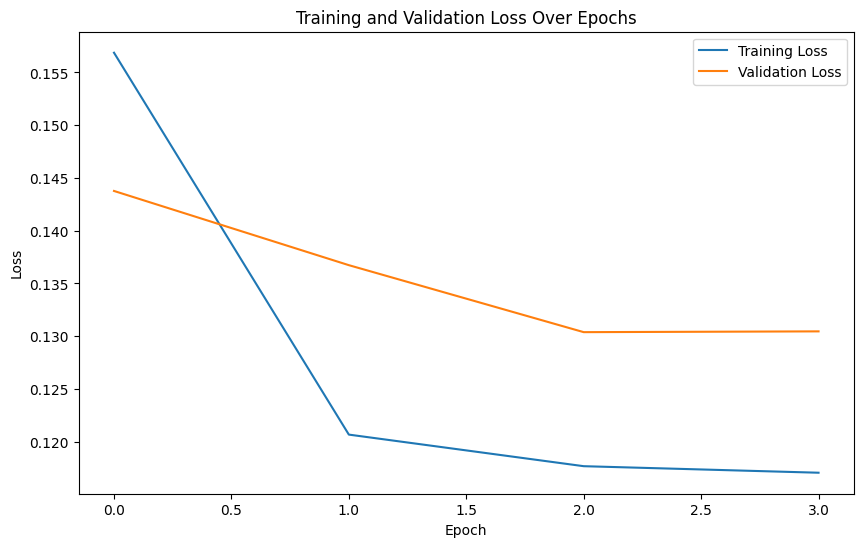

In [29]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

The training and validation plot shows that the loss are low and we are preventing overfitting well.

In [31]:
# Save the state dictionary of the trained model
torch.save(model.state_dict(), "trained_10_percent_model_state_dict.pt")

### Predicting depression with arbitrary post

There is no point in building a classifier if it is not used to do real task. So I want to try classifying an arbitrary post from the dataset. The post says "I'm so sad and can't do anything in life" which textually seems depressing.

In [32]:
# Load the tokenizer
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

def preprocess_text(text):
    # Tokenize and prepare input for the model
    inputs = tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors="pt")
 
    # Decode the tokens to see them in text form
    tokens = tokenizer.tokenize(text)
    token_ids = tokenizer.convert_tokens_to_ids(tokens)

    print("Tokens:", tokens)
    print("Token IDs:", token_ids)
    print("Input IDs (padded):", inputs['input_ids'].tolist())

    return inputs

def predict(model, text):
    model.eval()  # Set model to evaluation mode
    inputs = preprocess_text(text)
    
    # Move inputs to GPU if available
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    inputs = {key: value.to(device) for key, value in inputs.items()}
    model.to(device)
    
    # Forward pass
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)  # Optional: to get probabilities
        pred = torch.argmax(probs, dim=1).item()  # Get the predicted class label
    
    return pred, probs

# Example text to classify
text = "I'm so sad and can't do anything in life."

# Get prediction
label, probabilities = predict(model, text)

print(f"Predicted label: {label}")
print(f"Probabilities: {probabilities}")




Tokens: ['i', "'", 'm', 'so', 'sad', 'and', 'can', "'", 't', 'do', 'anything', 'in', 'life', '.']
Token IDs: [1045, 1005, 1049, 2061, 6517, 1998, 2064, 1005, 1056, 2079, 2505, 1999, 2166, 1012]
Input IDs (padded): [[101, 1045, 1005, 1049, 2061, 6517, 1998, 2064, 1005, 1056, 2079, 2505, 1999, 2166, 1012, 102]]
Predicted label: 1
Probabilities: tensor([[0.0721, 0.9279]], device='cuda:0')


The softmax gave us a probability tensor of [0.0721, 0.9279] telling us that the post is 7.21% not depressing and 92.79% depressing which seems reasonable.

### Confusion Matrix of Small BERT result

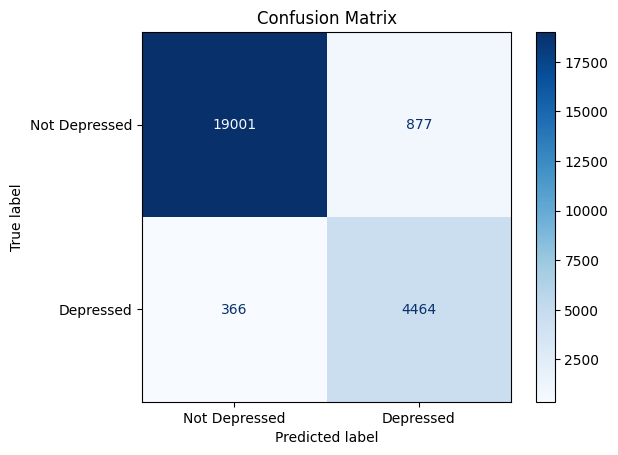

In [33]:
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, test_dataloader, class_names):
    model.eval()
    predictions, true_labels = [], []

    # Add progress bar to track progress through test_dataloader
    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc="Generating Predictions", leave=False):
            input_ids = batch['input_ids'].to('cuda')
            attention_mask = batch['attention_mask'].to('cuda')
            labels = batch['labels'].to('cuda')
            
            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

# Example usage
class_names = ["Not Depressed", "Depressed"]  # Adjust class names to match your model’s output classes
plot_confusion_matrix(model, test_dataloader, class_names)


The confusion matrix provides a detailed evaluation of the depression classifier's performance. The model correctly identified 19,001 cases as "Not Depressed" and 4,464 cases as "Depressed," demonstrating high accuracy in both categories. However, it also misclassified 877 cases as "Depressed" when they were "Not Depressed," reflecting false positives, and missed 366 cases of actual depression, resulting in false negatives. This aligns with the earlier analysis, where the classifier exhibited high recall (92.42%), effectively identifying most actual cases of depression while maintaining a reasonable precision (83.58%). The balance between true positives and false negatives shows that the model is well-suited for detecting depression, although the slightly elevated false positive rate suggests room for improvement in fine-tuning the decision threshold to enhance precision without compromising recall.

## Full dataset Fine-tuned Bert 

I am reusing the same code to train the smaller BERT, but now with the entire dataset.

In [ ]:
# Enable CUDA synchronization for accurate error traces
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'

# Load a pre-trained BERT model with a classification head
config = BertConfig.from_pretrained("bert-base-uncased", hidden_dropout_prob=0.3, attention_probs_dropout_prob=0.3, num_labels=2)
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", torch_dtype=torch.float16, config=config)
model = model.to('cuda')

# Optimizer
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=0.01)

# Scheduler
scheduler = StepLR(optimizer, step_size=1, gamma=0.1)  # Decreases LR by 0.1 every epoch

# Initialize GradScaler for mixed precision
scaler = GradScaler()

# Ensure all model parameters are in float32 to prevent FP16 gradient errors
model = model.to(torch.float32).to('cuda')

def train(model, train_dataloader, val_dataloader, optimizer, scheduler, scaler, epochs=3, start_epoch=0, checkpoint_dir="checkpoints"):
    train_losses = []
    val_losses = []
    for epoch in range(start_epoch , epochs):
        print(f"Epoch {epoch }/{epochs}")
        
        # Training phase
        model.train()  # Set model to training mode
        batch_train_losses = []
        
        # Initialize progress bar for training
        train_progress = tqdm(train_dataloader, desc="Training", leave=False)
        
        for batch in train_progress:
            input_ids = batch['input_ids'].to('cuda')
            attention_mask = batch['attention_mask'].to('cuda')
            labels = batch['labels'].to('cuda').long()

            optimizer.zero_grad()  # Clear previous gradients

            # Mixed precision forward pass
            with autocast(device_type="cuda"):
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                batch_train_losses.append(loss.item())  # Save batch loss
            # Backpropagation with scaled loss
            scaler.scale(loss).backward()

            # Unscales gradients before the optimizer step to handle NaNs/Infs
            scaler.unscale_(optimizer)

            # Check for NaN or Inf in gradients
            found_inf = False
            for param in model.parameters():
                if param.grad is not None and torch.isnan(param.grad).any():
                    found_inf = True
                    break

            # Skip optimizer step if NaNs/Infs are found
            if not found_inf:
                scaler.step(optimizer)
                scaler.update()  # Adjust scaling factor
            else:
                print("NaN or Inf detected in gradients; skipping optimizer step")

            # Update progress bar with current batch loss
            train_progress.set_postfix({"Batch Loss": loss.item()})

        avg_train_loss = sum(batch_train_losses) / len(batch_train_losses)
        train_losses.append(avg_train_loss) 
        print(f"Training loss: {avg_train_loss}")
        
        # Step the scheduler
        scheduler.step()
        print(f"Learning rate: {scheduler.get_last_lr()[0]}")

        # Save checkpoint at the end of each epoch
        save_checkpoint(epoch, model, optimizer, scheduler, scaler, checkpoint_dir)
        
        # Validation phase
        model.eval()  # Set model to evaluation mode
        batch_val_losses = []  # Track validation loss for each batch
        predictions, true_labels = [], []

        # Initialize progress bar for validation
        val_progress = tqdm(val_dataloader, desc="Validating", leave=False)
        
        with torch.no_grad():  # No gradient tracking
            for batch in val_progress:
                input_ids = batch['input_ids'].to('cuda')
                attention_mask = batch['attention_mask'].to('cuda')
                labels = batch['labels'].to('cuda').long()
                
                outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                batch_val_losses.append(loss.item())  # Save batch loss
                
                # Get predictions
                logits = outputs.logits
                preds = torch.argmax(logits, dim=1)
                
                predictions.extend(preds.cpu().numpy())
                true_labels.extend(labels.cpu().numpy())

                # Update progress bar with current batch loss
                val_progress.set_postfix({"Batch Loss": loss.item()})
                
        avg_val_loss = sum(batch_val_losses) / len(batch_val_losses)
        val_losses.append(avg_val_loss)  # Extend by batch losses

        accuracy = accuracy_score(true_labels, predictions)
        precision = precision_score(true_labels, predictions)
        recall = recall_score(true_labels, predictions)
        f1 = f1_score(true_labels, predictions)
        
        print(f"Validation loss: {avg_val_loss}")
        print(f"Validation Accuracy: {accuracy}")
        print(f"Validation Precision: {precision}")
        print(f"Validation Recall: {recall}")
        print(f"Validation F1 Score: {f1}")
    return train_losses, val_losses


checkpoint_path = "full_checkpoints/checkpoint_epoch_X.pt"  # Replace X with the last saved epoch number if resuming
if os.path.exists(checkpoint_path):
    start_epoch = load_checkpoint(checkpoint_path, model, optimizer, scheduler, scaler)
else:
    start_epoch = 0

# Run the training with progress tracking and capture losses
train_losses, val_losses = train(model, full_train_dataloader, full_val_dataloader, optimizer, scheduler, scaler, epochs=4, start_epoch=start_epoch, checkpoint_dir="full_checkpoints")




Epoch 0/4                                  <br>                                  
Training loss: 0.11490880630247327<br> 
Learning rate: 1.0000000000000002e-06<br> 
Checkpoint saved at full_checkpoints\checkpoint_epoch_0.pt<br> 
                                                                                   
Validation loss: 0.09718310372073038<br> 
Validation Accuracy: 0.9630828884472633<br> 
Validation Precision: 0.8994302344646663<br> 
Validation Recall: 0.9123890309569845<br> 
Validation F1 Score: 0.9058632896760277<br> 

Epoch 1/4                            <br>                                    
Training loss: 0.0886570965082907<br> 
Learning rate: 1.0000000000000002e-07<br> 
Checkpoint saved at full_checkpoints\checkpoint_epoch_1.pt<br> 
                                                                                   
Validation loss: 0.09556554545194375<br> 
Validation Accuracy: 0.9639490502576225<br> 
Validation Precision: 0.9001960544050974<br> 
Validation Recall: 0.916422378843635<br> 
Validation F1 Score: 0.9082367485705455<br> 

Epoch 2/4                                       <br>                                      
Training loss: 0.08532773130439214<br> 
Learning rate: 1.0000000000000004e-08<br> 
Checkpoint saved at full_checkpoints\checkpoint_epoch_2.pt<br> 
                                                                                    
Validation loss: 0.09525346834103048<br> 
Validation Accuracy: 0.9641271396018084<br> 
Validation Precision: 0.9021070755103714<br> 
Validation Recall: 0.9150294184910289<br> 
Validation F1 Score: 0.9085222991732637<br> 

Epoch 3/4                                      <br>                                     
Training loss: 0.08514531614073396<br> 
Learning rate: 1.0000000000000005e-09<br> 
Checkpoint saved at full_checkpoints\checkpoint_epoch_3.pt<br> 
                                                                                    
Validation loss: 0.09539813443800732<br> 
Validation Accuracy: 0.9640704748104765<br> 
Validation Precision: 0.9015027434280567<br> 
Validation Recall: 0.9154660180045323<br> 
Validation F1 Score: 0.9084307273346193<br> 

### Evaluating BERT Training Process on the Full Dataset
The training process for the BERT classifier on the full dataset was completed in a little over 6 hours, demonstrating consistent improvement over four epochs. 

The training loss steadily decreased from 0.1149 in epoch 0 to 0.0851 in epoch 3, indicating effective learning and optimization by the model. The gradient optimizer performed well, ensuring a smooth convergence.


The validation loss remained low, decreasing from 0.0971 in epoch 0 to 0.0954 in epoch 3, showcasing the model's ability to generalize well to unseen data. Validation accuracy improved slightly over the epochs, reaching 96.41%, which reflects the model's strong performance in correctly classifying samples. Precision improved marginally, from 89.94% to 90.15%, reflecting the model's ability to reduce false positives. Recall increased from 91.23% to 91.55%, ensuring fewer false negatives, which is critical for depression classification. The F1 score increased from 90.58% to 90.84%, indicating a balanced improvement in both precision and recall, and demonstrating the robustness of the classifier.

The learning rate decreased progressively across epochs, starting at 1e-6 and dropping to 1e-9, thanks to the scheduler. This ensured stable and gradual updates to the model weights, preventing overfitting or divergence.

The consistent reduction in training and validation losses, along with high and stable precision, recall, and F1 scores, highlights the model's capability to handle the complexity of the full dataset. I think the classifier is well-optimized and ready for deployment or further fine-tuning, as needed.

In [ ]:
# Testing phase
def test(model, test_dataloader):
    model.eval()
    predictions, true_labels = [], []
    
    # Add progress bar for the test dataloader
    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc="Testing", leave=False):
            input_ids = batch['input_ids'].to('cuda')
            attention_mask = batch['attention_mask'].to('cuda')
            labels = batch['labels'].to('cuda')
            
            outputs = model(input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    # Calculate metrics
    accuracy = accuracy_score(true_labels, predictions)
    precision = precision_score(true_labels, predictions)
    recall = recall_score(true_labels, predictions)
    f1 = f1_score(true_labels, predictions)
    
    print(f"Test Accuracy: {accuracy}")
    print(f"Test Precision: {precision}")
    print(f"Test Recall: {recall}")
    print(f"Test F1 Score: {f1}")

test(model, full_test_dataloader)



Test Accuracy: 0.9691597863040311 <br>
Test Precision: 0.9157808667211774 <br>
Test Recall: 0.927536231884058 <br>
Test F1 Score: 0.9216210656243571 <br>

These scores are good because all metrics are higher than the baseline and the small bert which shows that a larger training set helps with accuracy. Although the improvement is small in some scoring metrics, the Full BERT has clear advantages over the small BERT and the baseline. The Full BERT has significantly higher recall than the baseline. Additionally the Full BERT outshines the flaw in the small BERT which is in its precision. Not only that, the accuracy is near 97% which makes this model very promising. Although the training time took 6.5 hours, it is not a big negative as training is a one time thing. 

### Plotting Loss

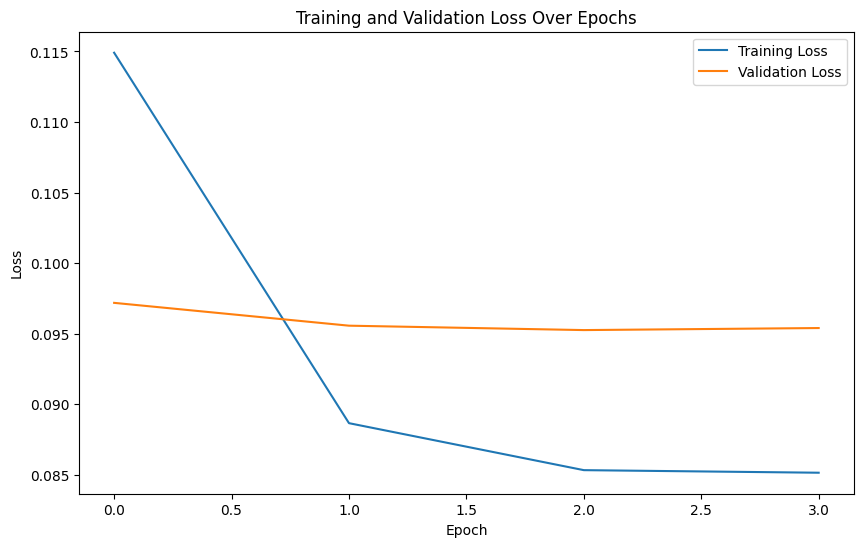

In [36]:
# Plotting the training and validation loss
plt.figure(figsize=(10, 6))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss Over Epochs')
plt.legend()
plt.show()

The training loss decreases steadily across the epochs, starting at approximately 0.115 and converging to around 0.085 by the end of training.
This indicates that the model is learning effectively and the optimizer is successfully minimizing the loss function.

The validation loss starts at around 0.097 and decreases slightly during the initial epochs, eventually stabilizing around 0.095.
The relatively stable validation loss across epochs suggests the model is generalizing well to unseen data, with no significant overfitting observed.

By the last epoch, the training and validation losses have plateaued, indicating that additional training would likely result in diminishing returns without further changes (e.g., learning rate adjustments or dataset augmentation).

The gap between training and validation loss is small, showing the model generalizes well and avoids overfitting. This balance highlights the robustness of the model on unseen test data.

The loss curves indicate successful training, with the model achieving both low training and validation losses.
The stability of the validation loss suggests that the model's performance on test data is likely consistent with validation metrics.
The full BERT model has effectively converged within the provided 4 epochs, making it suitable for deployment or further testing on the test dataset

In [37]:
# Save the state dictionary of the trained model
torch.save(model.state_dict(), "trained_model_state_dict.pt")


In [38]:
# Loading the fine-tuned model
# Initialize the same model architecture
# model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=2)
# model.load_state_dict(torch.load("trained_small_model_state_dict.pt"))
# model.to('cuda')  # Move to GPU if needed

In [39]:
import torch

# Check if CUDA is available
print("CUDA available:", torch.cuda.is_available())

# Get GPU details
if torch.cuda.is_available():
    print("GPU name:", torch.cuda.get_device_name(0))
    print("Memory Allocated:", torch.cuda.memory_allocated(0))
    print("Memory Cached:", torch.cuda.memory_reserved(0))

CUDA available: True
GPU name: NVIDIA GeForce RTX 4070
Memory Allocated: 7320044544
Memory Cached: 10781458432


### Predicting Arbitrary Post with Full BERT

In [102]:
# Load the tokenizer
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

def preprocess_text(text):
    # Tokenize and prepare input for the model
    inputs = tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors="pt")
 
    # Decode the tokens to see them in text form
    tokens = tokenizer.tokenize(text)
    token_ids = tokenizer.convert_tokens_to_ids(tokens)

    print("Tokens:", tokens)
    print("Token IDs:", token_ids)
    print("Input IDs (padded):", inputs['input_ids'].tolist())

    return inputs

def predict(model, text):
    model.eval()  # Set model to evaluation mode
    inputs = preprocess_text(text)
    
    # Move inputs to GPU if available
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    inputs = {key: value.to(device) for key, value in inputs.items()}
    model.to(device)
    
    # Forward pass
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.softmax(logits, dim=1)  # Optional: to get probabilities
        pred = torch.argmax(probs, dim=1).item()  # Get the predicted class label
    
    return pred, probs

# Example text to classify
text = "I'm so sad and can't do anything in life."

# Get prediction
label, probabilities = predict(model, text)

print(f"Predicted label: {label}")
print(f"Probabilities: {probabilities}")




Tokens: ['i', "'", 'm', 'so', 'sad', 'and', 'can', "'", 't', 'do', 'anything', 'in', 'life', '.']
Token IDs: [1045, 1005, 1049, 2061, 6517, 1998, 2064, 1005, 1056, 2079, 2505, 1999, 2166, 1012]
Input IDs (padded): [[101, 1045, 1005, 1049, 2061, 6517, 1998, 2064, 1005, 1056, 2079, 2505, 1999, 2166, 1012, 102]]
Predicted label: 1
Probabilities: tensor([[0.1265, 0.8735]], device='cuda:0')


The softmax gave us a probability tensor of [0.1265, 0.8735] telling us that the post is 12.65% not depressing and 87.35% depressing which seems reasonable. Note that the probability for not depressing from the full bert is higher than the probability of not depressing from the small bert. This may be why the full BERT model have higher precision by being more robust in posts that do not lean too far into a side.

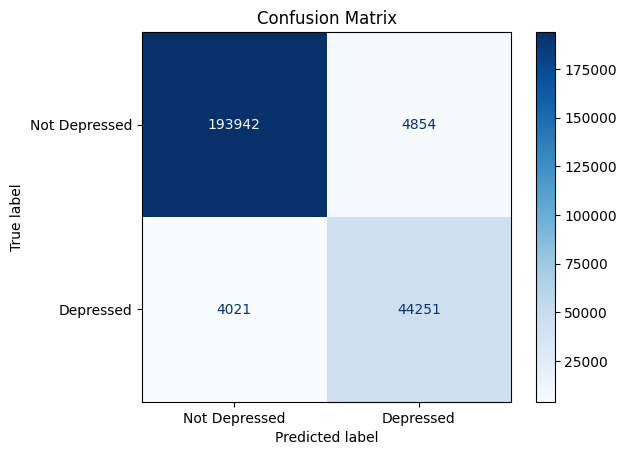

In [43]:
from tqdm import tqdm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

def plot_confusion_matrix(model, test_dataloader, class_names):
    model.eval()
    predictions, true_labels = [], []

    # Add progress bar to track progress through test_dataloader
    with torch.no_grad():
        for batch in tqdm(test_dataloader, desc="Generating Predictions", leave=False):
            input_ids = batch['input_ids'].to('cuda')
            attention_mask = batch['attention_mask'].to('cuda')
            labels = batch['labels'].to('cuda')
            
            outputs = model(input_ids, attention_mask=attention_mask)
            preds = torch.argmax(outputs.logits, dim=1)
            
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    # Compute confusion matrix
    cm = confusion_matrix(true_labels, predictions)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues')
    plt.title("Confusion Matrix")
    plt.show()

# Example usage
class_names = ["Not Depressed", "Depressed"]  # Adjust class names to match your model’s output classes
plot_confusion_matrix(model, full_test_dataloader, class_names)


### Analysis of the Confusion Matrix for Full BERT

1. **True Negatives (193,942)**:
   - The model correctly identified a large majority of "Not Depressed" samples as "Not Depressed."
   - This demonstrates excellent performance in avoiding false positives for this category.

2. **False Positives (4,854)**:
   - A small number of "Not Depressed" samples were misclassified as "Depressed."
   - While precision is high, these false positives highlight areas where the model's sensitivity may slightly overextend.

3. **False Negatives (4,021)**:
   - A relatively small number of "Depressed" samples were incorrectly classified as "Not Depressed."
   - This indicates strong recall, as the model successfully identifies the majority of true "Depressed" cases, reducing the risk of missing critical cases.

4. **True Positives (44,251)**:
   - The model correctly classified a substantial number of "Depressed" samples as "Depressed."
   - This reinforces its effectiveness in detecting depression, which is crucial in applications where missing true cases could have serious consequences.



#### **Performance Metrics**
1. **Precision (91.58%)**:
   - The model maintains high precision, effectively minimizing false positives and ensuring that most samples classified as "Depressed" are correct.

2. **Recall (92.75%)**:
   - The high recall reflects the model's ability to identify the majority of "Depressed" samples, reducing the likelihood of false negatives.

3. **F1 Score (92.16%)**:
   - The balance between precision and recall is evident from the F1 score, confirming that the model is robust and performs well across both metrics.


## Results

### Comparison: Full BERT vs. Small BERT vs. Baseline (Logistic Regression)

#### **1. Accuracy**
- **Full BERT**: **96.92%**
- **Small BERT**: **94.97%**
- **Baseline**: **94.23%**

**Analysis**: Full BERT achieves the highest accuracy, indicating its superior ability to classify both depressed and non-depressed cases correctly. Small BERT shows a slight improvement over the baseline but remains behind full BERT.



#### **2. Precision**
- **Full BERT**: **91.58%**
- **Small BERT**: **83.58%**
- **Baseline**: **88.25%**

**Analysis**: Full BERT outperforms both small BERT and the baseline in precision, effectively minimizing false positives. This makes it the best choice in scenarios where false positives must be kept low.



#### **3. Recall**
- **Full BERT**: **92.75%**
- **Small BERT**: **92.42%**
- **Baseline**: **81.17%**

**Analysis**: Both BERT models significantly outperform the baseline in recall, highlighting their ability to correctly identify true cases of depression. Full BERT slightly edges out small BERT in recall, ensuring it captures more true positives.



#### **4. F1 Score**
- **Full BERT**: **92.16%**
- **Small BERT**: **87.78%**
- **Baseline**: **84.56%**

**Analysis**: Full BERT has the highest F1 score, reflecting its superior balance between precision and recall. Small BERT improves upon the baseline but lags behind full BERT due to its lower precision.



### **Summary of Insights**
1. **Full BERT**:
   - Excels across all metrics, with the highest accuracy (96.92%), precision (91.58%), recall (92.75%), and F1 score (92.16%).
   - Demonstrates a strong balance of precision and recall, making it the most robust model for depression classification.

2. **Small BERT**:
   - Shows competitive recall (92.42%) and decent accuracy (94.97%), outperforming the baseline.
   - Precision (83.58%) is lower than the baseline, impacting its overall F1 score (87.78%).

3. **Baseline (Logistic Regression)**:
   - While simpler and faster, it lags significantly behind both BERT models in recall (81.17%) and F1 score (84.56%).
   - Precision (88.25%) is higher than small BERT but lower than full BERT.



### **Recommendation**
- **Full BERT** is the clear choice for applications requiring high performance, as it leads in all metrics.
- **Small BERT** is suitable when computational resources are limited but still delivers strong recall.
- The **Baseline** serves as a fast, lightweight option but is outperformed in key metrics by both BERT models.

However, if I am pushing a model to my client, I would only deploy the full BERT since the only thing that matter is accuracy. Full BERT simply has the best scores and took 6.5 hours to train which is standard when working with large text data. 

## Studying Attention with Word Cloud

To better understand the inner workings of our model, we aim to examine words that receive higher attention scores. By analyzing these high-attention words, we can gain insights into the linguistic patterns and features the model focuses on when making predictions, particularly in the context of detecting depressive language.

#### **Methodology**
To achieve this, we utilized the Integrated Gradients (IG) technique, a popular attribution method for interpreting neural network models. IG computes the contribution of each input feature (in this case, words or tokens) to the model’s output by integrating gradients along a path from a baseline to the actual input. 

1. **Tokenization and Embedding**:
   - Each text sample is tokenized into subwords using the BERT tokenizer. The tokenized input is then converted into embeddings by the BERT model.

2. **Baseline and Attributions**:
   - A baseline input, typically consisting of zero embeddings, is defined to serve as a reference. Integrated Gradients computes the gradients of the model's output with respect to the input embeddings, starting from the baseline and moving towards the actual embeddings. The cumulative gradients along this path represent the attributions, which indicate the importance of each token in the model's decision-making.

3. **Mapping Tokens to Words**:
   - Once the attributions are computed, they are aggregated at the word level to account for subwords generated by the tokenizer. For instance, subword tokens like "depress" and "##ion" are combined into "depression," with their attribution scores summed.

4. **Filtering and Visualization**:
   - To create a meaningful visualization, we filter out stop words and punctuation, as these are unlikely to carry significant semantic weight in the classification task. The remaining words and their aggregated attribution scores are then visualized as a word cloud, where the size of each word corresponds to its importance based on the attributions.

This method allows us to identify the key linguistic features that drive the model’s predictions, providing valuable interpretability and insights into the relationship between language and depression detection. By visualizing the model's attention in a word cloud, we can better understand the patterns and nuances it captures, aiding in both model evaluation and refinement.

In [103]:
from captum.attr import IntegratedGradients
import numpy as np

def forward_func(embeddings, attention_mask):
    """
    Forward function for Captum, passing embeddings directly.
    """
    outputs = model(input_ids=None, attention_mask=attention_mask, inputs_embeds=embeddings)
    return outputs.logits



# Initialize Integrated Gradients
ig = IntegratedGradients(forward_func)

def compute_attributions(text, label):
    """
    Compute attributions using Integrated Gradients on embeddings.
    """
    # Tokenize and move to device
    inputs = tokenizer(text, padding=True, truncation=True, max_length=128, return_tensors="pt")
    input_ids = inputs['input_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)

    # Retrieve embeddings for input_ids
    with torch.no_grad():
        embeddings = model.bert.embeddings.word_embeddings(input_ids)

    # Define baseline as zero embeddings
    baseline = torch.zeros_like(embeddings).to(device)

    # Compute attributions
    attributions, delta = ig.attribute(
        inputs=embeddings,  # Pass embeddings directly
        baselines=baseline,  # Baseline embeddings
        additional_forward_args=(attention_mask,),  # Pass attention mask
        target=int(label),  # Ensure label is an integer
        return_convergence_delta=True
    )

    # Aggregate attributions across embedding dimensions
    attributions = attributions.sum(dim=-1).squeeze(0).cpu().detach().numpy()  # Shape: [seq_len]

    # Map token IDs back to words
    tokens = tokenizer.convert_ids_to_tokens(input_ids[0])
    return tokens, attributions





In [104]:
from tqdm import tqdm
from collections import defaultdict

word_attributions = defaultdict(float)

# Number of samples to process
num_samples = 2000  # Adjust for dataset size
processed_samples = 0  # Counter for processed samples

# Use tqdm to track progress
with tqdm(total=num_samples, desc="Processing Attributions") as progress_bar:
    for i, batch in enumerate(full_train_dataloader):
        if processed_samples >= num_samples:
            break

        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Decode input texts
        texts = tokenizer.batch_decode(input_ids, skip_special_tokens=True)

        # Compute attributions for each text in the batch
        for text, label in zip(texts, labels):
            if processed_samples >= num_samples:
                break

            tokens, attributions = compute_attributions(text, label.item())

            # Aggregate subword attributions
            current_word = ""
            current_attr = 0.0
            for token, attr in zip(tokens, attributions):
                if token.startswith("##"):
                    current_word += token[2:]
                else:
                    if current_word:
                        word_attributions[current_word] += current_attr
                    current_word = token
                    current_attr = 0.0
                current_attr += attr
            if current_word:
                word_attributions[current_word] += current_attr

            # Update progress
            processed_samples += 1
            progress_bar.update(1)


Processing Attributions: 100%|██████████| 2000/2000 [2:45:37<00:00,  4.97s/it]  


In [105]:
# Remove special tokens like [CLS], [SEP], [PAD]
special_tokens = set(tokenizer.all_special_tokens)
word_attributions = {word: score for word, score in word_attributions.items() if word not in special_tokens}

# Normalize attributions
words = list(word_attributions.keys())
scores = list(word_attributions.values())
min_score = np.min(scores)
max_score = np.max(scores)
normalized_scores = (np.array(scores) - min_score) / (max_score - min_score)

# Create a dictionary for the word cloud
word_cloud_data = {word: score for word, score in zip(words, normalized_scores)}


In [106]:
import nltk
from nltk.corpus import stopwords
import string
import re


nltk.download('stopwords')

# Get the stop words set
stop_words = set(stopwords.words('english'))
punctuation = set(string.punctuation)


# Optionally add custom stop words
custom_stop_words = {'would', 'could', 'should', 'also', 'however', 'subreddit', 'reddit'}
stop_words.update(custom_stop_words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Benja\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [107]:
def filter_word(word):
    # Remove punctuation and stop words
    word = word.lower()
    return word not in stop_words and word not in punctuation and not re.match(r'^\W+$', word)

filtered_word_attributions = {
    word: score for word, score in word_attributions.items() if filter_word(word)
}


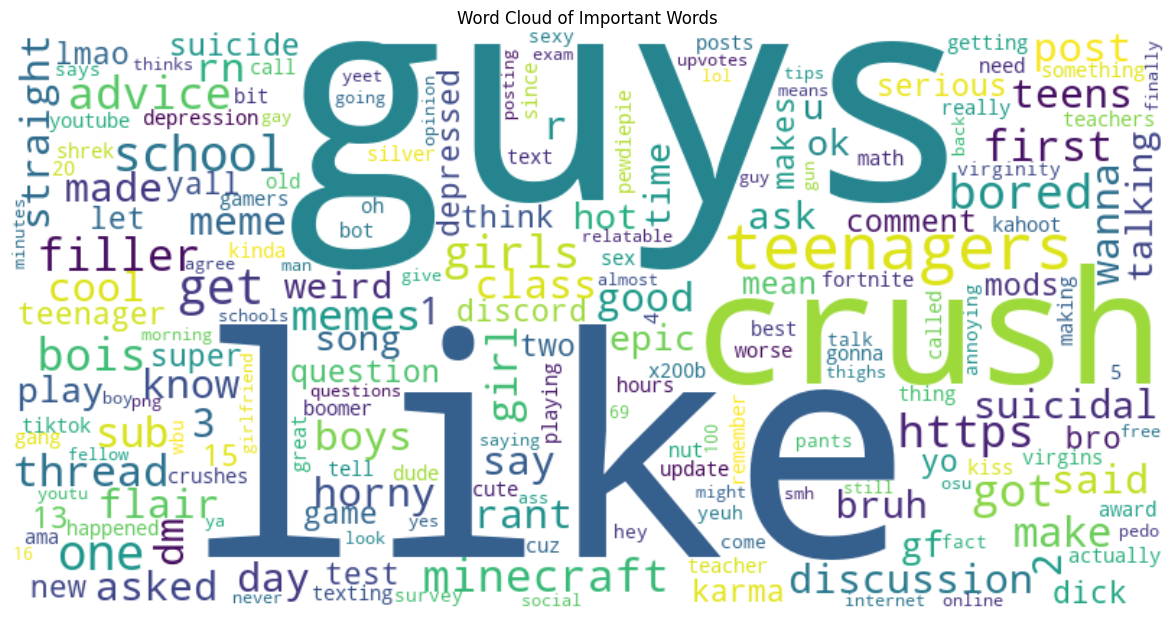

In [109]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Generate word cloud
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis'
).generate_from_frequencies(filtered_word_attributions)

# Display the word cloud
plt.figure(figsize=(15, 7.5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Important Words")
plt.show()


### **Analysis of the Word Cloud**

The word cloud represents the most influential words identified by the model during a classification task, where attribution scores were calculated using Integrated Gradients. The method involved tokenizing the text data using the BERT tokenizer and computing attribution scores for each token to estimate its contribution to the model’s predictions. Words with higher scores appear larger in the word cloud, reflecting their relative importance in the classification process. After tokenization, stop words and punctuation were removed to focus on meaningful terms, and tokens were mapped back to words for interpretability. 

Dominant words like **"guys," "like," "crush," "teenagers," "school,"** and **"time"** suggest that the dataset primarily revolves around teenage conversations and interactions. These terms likely represent the general context of the dataset, which seems to focus on social dynamics, relationships, and everyday activities. Emotional and contextual words such as **"depressed," "suicidal," "advice," "bored," "rant,"** and **"serious"** point toward discussions related to mental health. These words likely contribute significantly to identifying the "depression" class, reflecting the dataset's emphasis on mental health concerns.

Themes of social and relational interactions are also evident in the word cloud. Words such as **"crush," "girls," "boys," "horny," "asked,"** and **"talking"** highlight the dataset's focus on teenage relationships and social dynamics. These terms might be associated with the "non-depression" class or could represent interpersonal challenges that overlap with mental health topics. Additionally, the presence of pop culture and internet-related terms, such as **"minecraft," "meme," "discord," "flair," "epic,"** and **"tiktok,"** reflects the influence of digital culture in the dataset, likely sourced from online forums or communities.

Some unexpected words like **"https," "thread," "sub,"** and **"post"** indicate potential structural noise in the dataset, such as URLs or forum metadata. These terms appear prominently in the word cloud but may not meaningfully contribute to the classification task. Their presence suggests a need for further preprocessing to remove such irrelevant elements, which could improve the model’s performance and the quality of future analyses.

The word cloud provides insights into the dataset's themes and the model's behavior. Words such as **"depressed," "suicidal,"** and **"serious"** likely align with the "depression" class, while terms like **"crush," "meme,"** and **"minecraft"** may be more associated with the "non-depression" class. However, the prominence of generic terms like **"guys"** and **"like"** raises questions about potential model biases, as these words might not carry strong semantic meaning but still influence predictions. 

To improve future analyses, additional preprocessing steps could remove noisy terms like **"https"** and **"thread,"** and class-specific word clouds could be created to better distinguish the linguistic patterns driving each classification. Overall, the word cloud reflects a mix of casual teenage conversations and mental health discussions, highlighting the complexity and diversity of the dataset and the potential challenges in modeling it effectively.

## References

1. Salik I, Marwaha R. StatPearls [Internet]. StatPearls Publishing; Treasure Island (FL): Sep 19, 2022. Electroconvulsive Therapy.